In [15]:
import numpy as np
import pandas as pd
import glob
import os

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from stesml.data_tools import get_dataframe
from stesml.data_tools import get_index_splits
from stesml.data_tools import get_split_data
from stesml.data_tools import get_scaled_data

from stesml.plot_tools import plot_results
from stesml.plot_tools import plot_average_error

In [3]:
%load_ext tensorboard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [4]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, 
    histogram_freq=1,
)

2022-07-18 18:48:54.594204: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-07-18 18:48:54.594223: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-07-18 18:48:54.595169: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [5]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=2,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [9]:
data_dir = "../data/Sulfur_Models/heating/heating_all"

scenario_index = pd.DataFrame({"filepath": glob.glob(os.path.join(data_dir, "ML_*_*.csv"))})

In [10]:
target = 'Tavg'

In [11]:
# Get the train and validation index by randomly splitting up data (80-20 train-val split)
train_index, val_index = get_index_splits(scenario_index)

In [13]:
# Get data for train and val splits
X_train, y_train = get_split_data(scenario_index, train_index, target)
X_val, y_val = get_split_data(scenario_index, val_index, target)

In [16]:
# Scale data to mean=0 & STD=1 improve model performance
X_train, y_train, scaler_X, scaler_y = get_scaled_data(X_train, y_train)
X_val, y_val = get_scaled_data(X_val, y_val, scaler_X, scaler_y)

In [17]:
# Get the model
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(3,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.build()

2022-07-18 18:50:11.289601: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 2,801
Trainable params: 2,801
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Fit the model to training data
model.fit(x=X_train, 
          y=y_train,
          batch_size=1000,
          epochs=20,
          validation_data=(X_val, y_val),
          callbacks=[earlystopping_callback])

2022-07-18 18:50:14.593690: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/20
2266/2266 [==============================] - 4s 1ms/step - loss: 0.0402 - val_loss: 0.0265
Epoch 2/20
2266/2266 [==============================] - 2s 1ms/step - loss: 1.5464e-04 - val_loss: 0.0242
Epoch 3/20
2266/2266 [==============================] - 2s 1ms/step - loss: 5.9505e-05 - val_loss: 0.0222
Epoch 4/20
2266/2266 [==============================] - 2s 1ms/step - loss: 4.5339e-05 - val_loss: 0.0215
Epoch 5/20
2266/2266 [==============================] - 2s 1ms/step - loss: 3.7019e-05 - val_loss: 0.0220
Epoch 6/20
2266/2266 [==============================] - 2s 1ms/step - loss: 3.1990e-05 - val_loss: 0.0220


In [20]:
# Get predictions for validation data
y_hat = model.predict(X_val)

In [21]:
# Reverse the data scaling process for target data
y_hat = scaler_y.inverse_transform(y_hat.reshape(-1,1)).reshape(1,-1)[0]
y_val = scaler_y.inverse_transform(y_val.reshape(-1,1)).reshape(1,-1)[0]

In [22]:
# Evaluate results
rmse = mean_squared_error(y_val, y_hat, squared=False)
print(rmse)

7.661333387685226


In [23]:
r2 = r2_score(y_val, y_hat)
print(r2)

0.9738158849821528


In [24]:
val_df = get_dataframe(scenario_index, val_index)
val_df[target+"_hat"] = y_hat

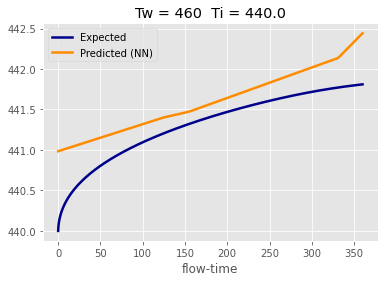

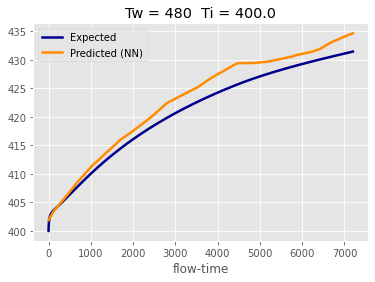

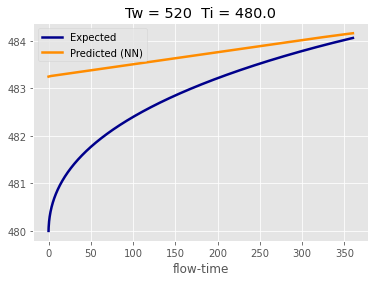

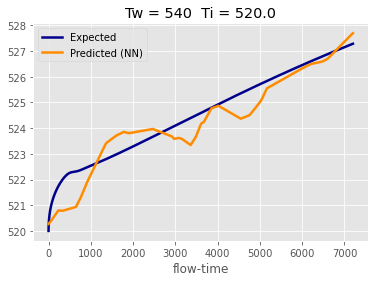

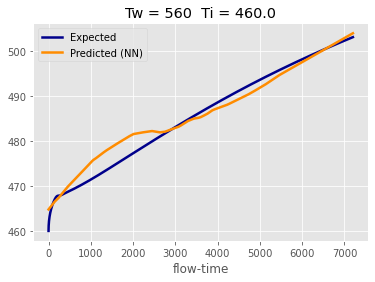

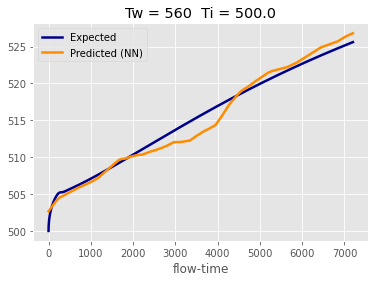

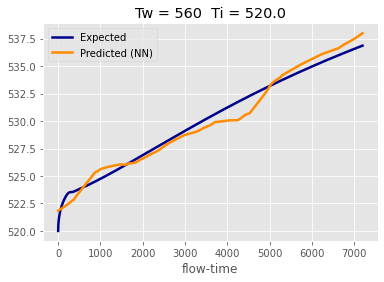

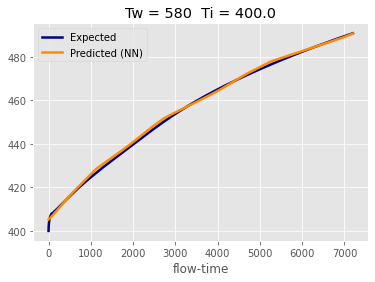

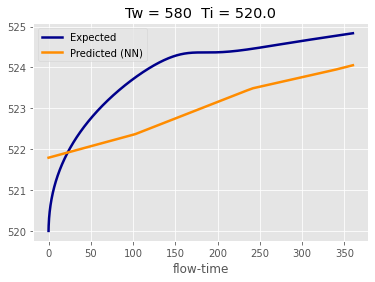

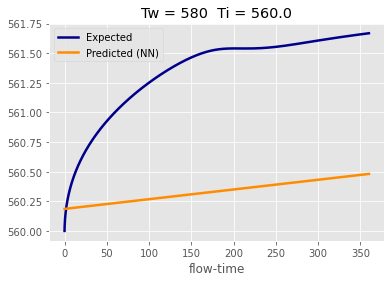

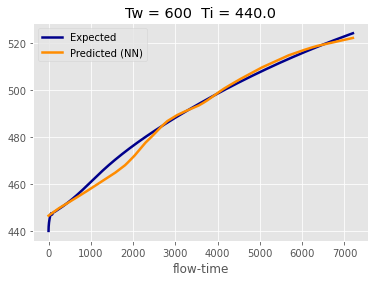

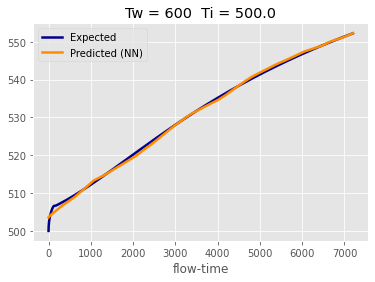

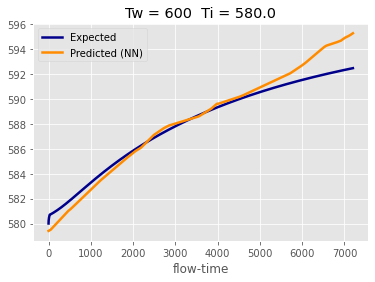

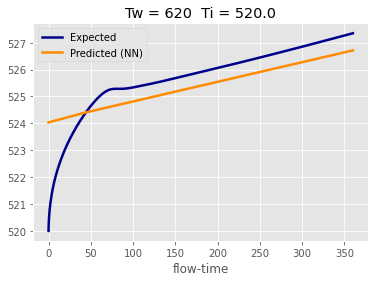

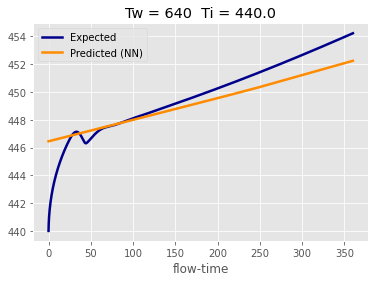

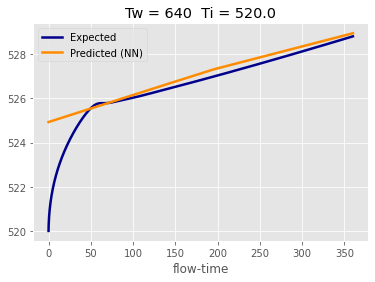

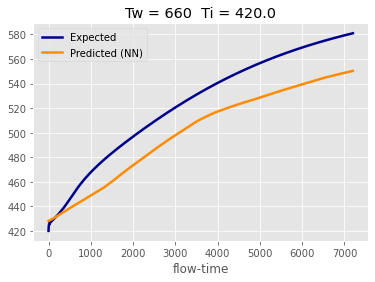

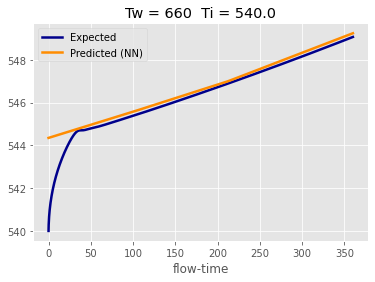

In [25]:
plot_results(val_df, 'NN', target)